In [ ]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import urllib

import tensorflow as tf
import tensorflow.compat.v2.feature_column as fc

In [2]:
# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [ ]:
#training data trains the model while testing checks (tests) whether this built model works correctly or not

# Our aim is to predict who's going to surive
# 0 > didn't survive    1 > survived

<Axes: >

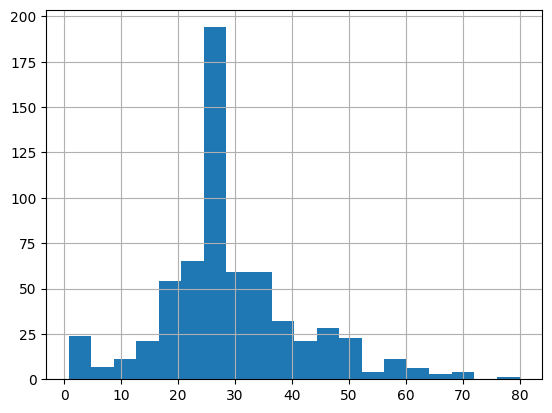

In [ ]:
dftrain.age.hist(bins=20)

<Axes: >

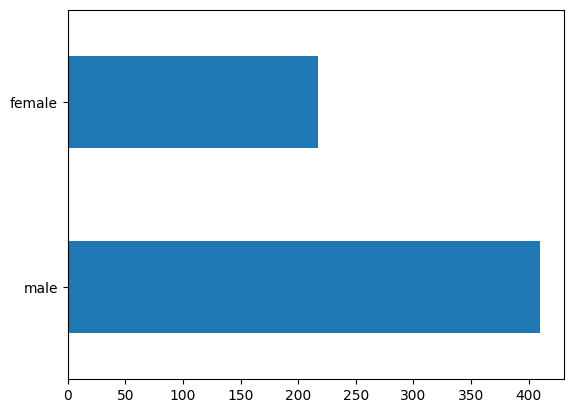

In [ ]:
dftrain.sex.value_counts().plot(kind='barh')

In [ ]:
# Categorical Data is data that we can turn into integers
CATEGORICAL_COLUMNS = ['sex','n_siblings_spouses','parch','class','deck','embark_town','alone']

NUMERIC_COLUMNS = ['age','fare']

# We need feature columns for linear regression, by doing this we get all of the coulmns and their data

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique() # gets a list of all unique values
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns)

In [ ]:
dftrain["sex"].unique()

array(['male', 'female'], dtype=object)

In [ ]:
# For large data models we need to load the data into batches (for simple df's like this one the system's RAM would be sufficient)
# For this model we are going to use 32 different batches

# Epochs > how many times the model will see the same dataset (to pick up patterns)
# Sometimes the data can be seen too many times (overfeeding)
# We make sure we start with a lower amount and then increase gradually

In [4]:
# INPUT FUNCTION
# It defines how the data is broken into epochs and batches to feed to our model

def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function(): # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df)) # creates tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000) # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs) # splits dataset into batches of 32 and repeats process for number of epochs
    return ds # returns a batch of the dataset
  return input_function # returns a function object for use

train_input_fn = make_input_fn(dftrain, y_train) # here we will call the input_function that was returned to us to get a dataset object we can use
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

In [5]:
# Creating the Model

linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

linear_est.train(train_input_fn) # train
result = linear_est.evaluate(eval_input_fn) # get model stats by testing on testing data

clear_output() # clears cosole output
print(result['accuracy']) # the result variable is simply a dict of stats about our model

0.75


In [ ]:
# ^ 75% accuracy ^
# not very good but ok as a first shot

In [8]:
# Actual predictions on the model:

result = list(linear_est.predict(eval_input_fn))
print(dfeval.loc[0]) # the person being analyzed
print(y_eval.loc[0]) # whether they actually survived or not
print(result[0]['probabilities']) # death and survival

sex                          male
age                          35.0
n_siblings_spouses              0
parch                           0
fare                         8.05
class                       Third
deck                      unknown
embark_town           Southampton
alone                           y
Name: 0, dtype: object
0
[0.9320055  0.06799451]


In [7]:
print(dfeval.loc[2]) # the person being analyzed
print(y_eval.loc[0]) # whether they actually survived or not
print(result[2]['probabilities']) # death and survival

sex                        female
age                          58.0
n_siblings_spouses              0
parch                           0
fare                        26.55
class                       First
deck                            C
embark_town           Southampton
alone                           y
Name: 2, dtype: object
0
[0.27447933 0.72552073]
